In [7]:
import geopandas as gpd
import pandas as pd
import numpy as np
import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import cm
import shapely
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import date
from matplotlib.colors import ListedColormap
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

## Datos abiertos del Gobierno de México

Fuente: [Dirección General de Epidemiología](https://www.gob.mx/salud/documentos/datos-abiertos-152127)

In [8]:
covid=pd.read_csv('http://187.191.75.115/gobmx/salud/datos_abiertos/datos_abiertos_covid19.zip')
covid=covid.dropna()

In [9]:
covid['MUNICIPIO_RES']=[str(int(i)) for i in covid['MUNICIPIO_RES']]
covid['ENTIDAD_RES']=[str(int(i)) for i in covid['ENTIDAD_RES']]
covid['mrg']=[i+j for i,j in zip(covid['ENTIDAD_RES'],covid['MUNICIPIO_RES'])]
covid.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,mrg
0,2020-04-20,09e8dc,2,9,15,1,15,15,37,2,...,2,2,2,2,1,99,99,97,1,1537
1,2020-04-20,1dd782,2,12,9,1,15,9,3,1,...,1,2,2,2,2,99,99,97,97,93
2,2020-04-20,0efbaf,2,9,28,2,16,28,32,1,...,2,2,2,1,1,99,99,97,97,2832
3,2020-04-20,013a6c,1,3,15,2,15,15,106,1,...,1,2,2,1,3,99,99,97,97,15106
4,2020-04-20,091a48,1,12,15,2,15,15,31,2,...,2,2,2,2,2,99,99,97,2,1531


## Shape de Municipios
Es necesario tenerlo descargado en su computadora

Fuente: [CONABIO](http://www.conabio.gob.mx/informacion/gis/)

In [10]:
mun=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/muni_2018gw/muni_2018gw.shp')

In [11]:
mun['MUNICIPIO_RES']=[str(int(i)) for i in mun.CVE_MUN]
mun['ENTIDAD_RES']=[str(int(i)) for i in mun.CVE_ENT]
mun['mrg']=[i+j for i,j in zip(mun['ENTIDAD_RES'],mun['MUNICIPIO_RES'])]
mu=mun[['geometry','mrg']]
mu.head()

,geometry,mrg
0,"POLYGON ((-102.09775 22.02325, -102.09857 22.0...",11
1,"POLYGON ((-101.99941 22.21951, -101.99940 22.2...",12
2,"POLYGON ((-102.57625 21.96778, -102.57626 21.9...",13
3,"POLYGON ((-102.25320 22.37449, -102.25239 22.3...",14
4,"POLYGON ((-102.31034 22.03716, -102.30653 22.0...",15


## Catálogo de Entidades

In [12]:
enti=mun[['NOM_ENT','ENTIDAD_RES']].drop_duplicates()
enti.head(10)

,NOM_ENT,ENTIDAD_RES
0,Aguascalientes,1
11,Baja California,2
16,Baja California Sur,3
21,Campeche,4
32,Coahuila de Zaragoza,5
70,Colima,6
80,Chiapas,7
203,Chihuahua,8
270,Ciudad de MÃ©xico,9
286,Durango,10


## Creación de una base de datos espacial
Join entre los datos del COVID19 y el SHP de municipios

In [13]:
geocv=gpd.GeoDataFrame(covid.merge(mu,on='mrg'))

In [14]:
geocv.head()

,FECHA_ACTUALIZACION,ID_REGISTRO,ORIGEN,SECTOR,ENTIDAD_UM,SEXO,ENTIDAD_NAC,ENTIDAD_RES,MUNICIPIO_RES,TIPO_PACIENTE,...,RENAL_CRONICA,TABAQUISMO,OTRO_CASO,RESULTADO,MIGRANTE,PAIS_NACIONALIDAD,PAIS_ORIGEN,UCI,mrg,geometry
0,2020-04-20,09e8dc,2,9,15,1,15,15,37,2,...,2,2,2,1,99,99,97,1,1537,"POLYGON ((-99.23962 19.41220, -99.23991 19.412..."
1,2020-04-20,1e5be0,2,9,15,1,15,15,37,1,...,2,1,2,2,99,99,97,97,1537,"POLYGON ((-99.23962 19.41220, -99.23991 19.412..."
2,2020-04-20,189250,2,9,15,2,15,15,37,1,...,2,2,2,2,99,99,97,97,1537,"POLYGON ((-99.23962 19.41220, -99.23991 19.412..."
3,2020-04-20,0b24df,2,9,15,2,15,15,37,1,...,2,2,2,2,99,México,97,97,1537,"POLYGON ((-99.23962 19.41220, -99.23991 19.412..."
4,2020-04-20,056fff,2,9,15,2,15,15,37,2,...,2,2,2,1,99,México,97,2,1537,"POLYGON ((-99.23962 19.41220, -99.23991 19.412..."


# Filtado de datos a infectados confirmados y conteo de los mismos por municipio

In [15]:
geocvp=geocv[geocv.RESULTADO==1]

In [16]:
count=geocvp.mrg.value_counts().reset_index()
count=count.rename(columns={'index':'mrg','mrg':'cnt'})
count.head()

,mrg,cnt
0,24,443
1,256,352
2,97,341
3,95,268
4,235,264


In [17]:
geofq=gpd.GeoDataFrame(count.merge(mu,on='mrg'))
geofq.crs={'init': 'epsg:4326'}

In [18]:
geofq

,mrg,cnt,geometry
0,24,443,"POLYGON ((-116.75525 32.55660, -116.75295 32.5..."
1,256,352,"POLYGON ((-107.14834 25.25916, -107.14772 25.2..."
2,97,341,"POLYGON ((-99.05813 19.40072, -99.05814 19.400..."
3,95,268,"POLYGON ((-99.11789 19.59059, -99.11860 19.584..."
4,235,264,"POLYGON ((-86.80184 21.21195, -86.80184 21.211..."
...,...,...,...
565,1477,1,"POLYGON ((-103.71463 20.51391, -103.71484 20.5..."
566,15119,1,"POLYGON ((-99.54972 18.88836, -99.55067 18.886..."
567,12,1,"POLYGON ((-101.99941 22.21951, -101.99940 22.2..."
568,30128,1,"POLYGON ((-97.23804 19.63680, -97.23724 19.636..."


## Graficación

/Users/Raul/anaconda3/lib/python3.7/site-packages/pyparsing.py:1316: MatplotlibDeprecationWarning: 
The \mathcircled mathtext command was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use unicode characters (e.g. '\N{CIRCLED LATIN CAPITAL LETTER A}' or '\u24b6') instead.
  ret = func(*args[limit[0]:])


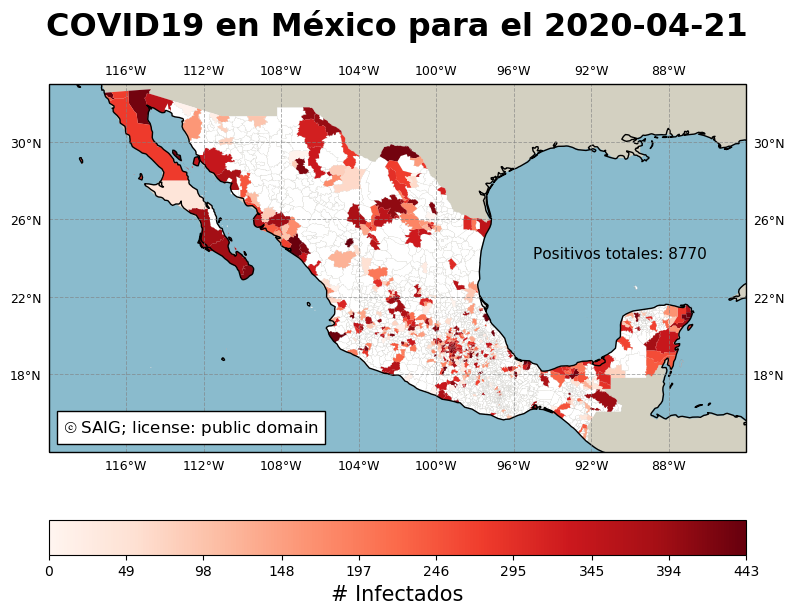

In [33]:
plt.figure(figsize=(9,9),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
xex=[-120,-84, 14, 33]
ax.set_extent(xex, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='#D3D0C1')
ax.add_feature(cfeature.OCEAN,facecolor='#8ABBCD')
norm = cm.colors.Normalize(vmax=geofq.cnt.max(), vmin=0)
cmap = cm.Reds
mu.plot(ax=ax,color='white',linewidth=.03,alpha=1,ec='gray')
geofq.plot(ax=ax,cmap=cm.get_cmap(cmap.reversed()))
ticks=np.round(np.linspace(0,int(geofq.cnt.max()),10))
cbar=plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,shrink=1,ticks=ticks,orientation='horizontal',pad=.1)
cbar.set_label('# Infectados',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.7, color='gray', alpha=0.6, linestyle='--')
gl.xlabels_top = True
gl.ylabels_left = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(xex[0], xex[1]+4,4))
gl.ylocator = mticker.FixedLocator(np.arange(xex[2],xex[3]+4,4))
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}
plt.title("COVID19 en México para el "+date.today().isoformat(),pad=35,fontsize=23,fontweight="bold")
plt.text(-95,24,"Positivos totales: "+str(np.sum(count.cnt)),fontsize=11)
SOURCE = 'SAIG'
LICENSE = 'public domain'
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=3, prop={'size': 12}, frameon=True)
ax.add_artist(text)
plt.savefig('cv'+date.today().isoformat()+'.png',dpi=800,bbox_inches='tight');

## Para la CDMX

In [20]:
cdmx=geofq[geofq.mrg.str[0]=='9']

In [21]:
cdmx.head()

,mrg,cnt,geometry
2,97,341,"POLYGON ((-99.05813 19.40072, -99.05814 19.400..."
3,95,268,"POLYGON ((-99.11789 19.59059, -99.11860 19.584..."
8,912,207,"POLYGON ((-99.20575 19.30568, -99.20567 19.305..."
9,910,183,"POLYGON ((-99.18906 19.39559, -99.18871 19.394..."
10,916,181,"POLYGON ((-99.16371 19.45643, -99.16372 19.456..."


/Users/Raul/anaconda3/lib/python3.7/site-packages/pyparsing.py:1316: MatplotlibDeprecationWarning: 
The \mathcircled mathtext command was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use unicode characters (e.g. '\N{CIRCLED LATIN CAPITAL LETTER A}' or '\u24b6') instead.
  ret = func(*args[limit[0]:])


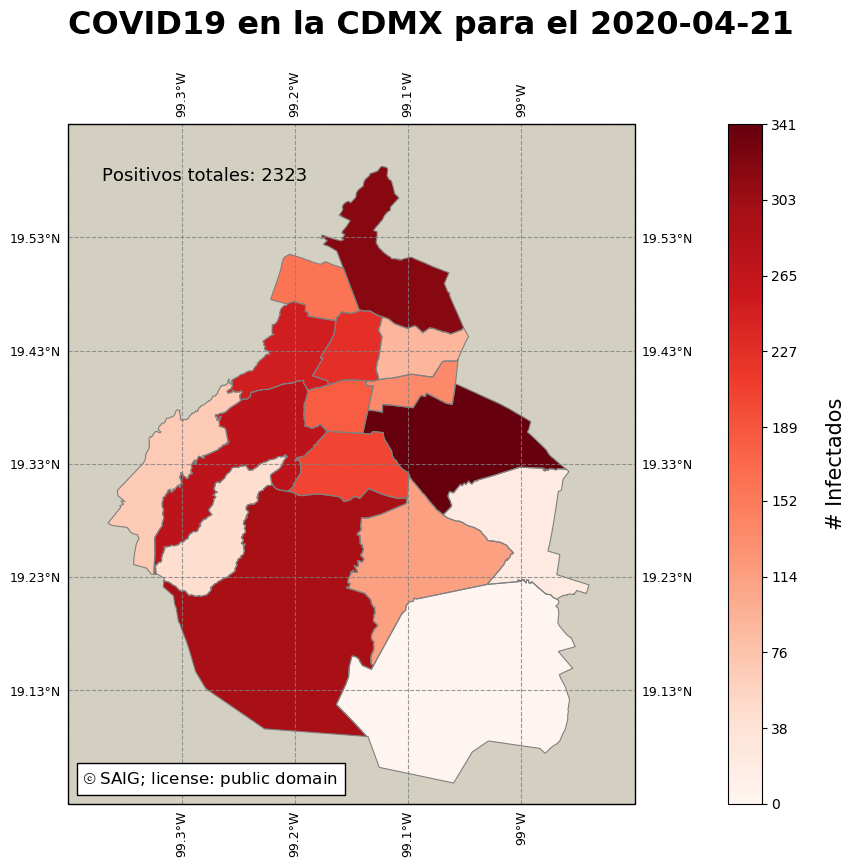

In [34]:
plt.figure(figsize=(12,9),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
xex=[-99.4,-98.9, 19.03, 19.63]
ax.set_extent(xex, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='#D3D0C1')
norm = cm.colors.Normalize(vmax=cdmx.cnt.max(), vmin=0)
cmap = cm.Reds
cdmx.plot(ax=ax,cmap=cm.get_cmap(cmap.reversed()))
mu[mu.mrg.str[0]=='9'].boundary.plot(ax=ax,color='gray',linewidth=.8,alpha=1)
ticks=np.round(np.linspace(0,int(cdmx.cnt.max()),10))
cbar=plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax,shrink=1,ticks=ticks,orientation='vertical',pad=.1)
cbar.set_label('# Infectados',fontsize=15,labelpad=20)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.8, color='gray', alpha=0.8, linestyle='--')
gl.xlabels_top = True
gl.ylabels_left = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(xex[0], xex[1]+.1,.1))
gl.ylocator = mticker.FixedLocator(np.arange(xex[2],xex[3]+.1,.1))
gl.xlabel_style = {'size': 9,'rotation':90}
gl.ylabel_style = {'size': 9}
plt.title("COVID19 en la CDMX para el "+date.today().isoformat(),pad=65,fontsize=23,fontweight="bold",loc='left')
plt.text(-99.37,19.58,"Positivos totales: "+str(np.sum(cdmx.cnt)),fontsize=13)
SOURCE = 'SAIG'
LICENSE = 'public domain'
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=3, prop={'size': 12}, frameon=True)
ax.add_artist(text)
plt.savefig('cdmx'+date.today().isoformat()+'.png',dpi=800,bbox_inches='tight');

## Análisis de vecinidad de municipios infectados

In [23]:
noninf=mu[~mu['mrg'].isin(geofq['mrg'])]

In [24]:
nongeom=noninf.geometry.reset_index(drop=True)
cod=noninf.mrg.reset_index(drop=True)

In [25]:
vec=[]
mg=[]

for i in geofq.geometry:
    
    c=0
    
    for j,m in zip(nongeom,cod):
        
        
        if j.intersects(i):
            
            vec.append(j)
            mg.append(m)
            
            nongeom=nongeom.drop(c)
            cod=cod.drop(c)
            
            
            
        c+=1
    
    nongeom=nongeom.reset_index(drop=True)
    cod=cod.reset_index(drop=True)

In [26]:
neig=gpd.GeoDataFrame({'geometry':vec,'lab':np.repeat('Vecino',len(vec)),'mrg':mg})
ais=gpd.GeoDataFrame({'geometry':nongeom,'lab':np.repeat('Aislado',len(nongeom)),'mrg':cod})
infc=gpd.GeoDataFrame({'geometry':geofq.geometry,'lab':np.repeat('Infectado',len(geofq)),'mrg':geofq.mrg})
cvmun=gpd.GeoDataFrame()
cvmun=cvmun.append(infc)
cvmun=cvmun.append(neig)
cvmun=cvmun.append(ais)

## Shape de estados 
Es necesario tenerlo descargado en su computadora

Fuente: [CONABIO](http://www.conabio.gob.mx/informacion/gis/)

In [27]:
est=gpd.read_file('/Users/Raul/Desktop/Programacion/Python/Covid/dest2018gw/dest2018gw.shp')

## Graficación

/Users/Raul/anaconda3/lib/python3.7/site-packages/pyparsing.py:1316: MatplotlibDeprecationWarning: 
The \mathcircled mathtext command was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use unicode characters (e.g. '\N{CIRCLED LATIN CAPITAL LETTER A}' or '\u24b6') instead.
  ret = func(*args[limit[0]:])


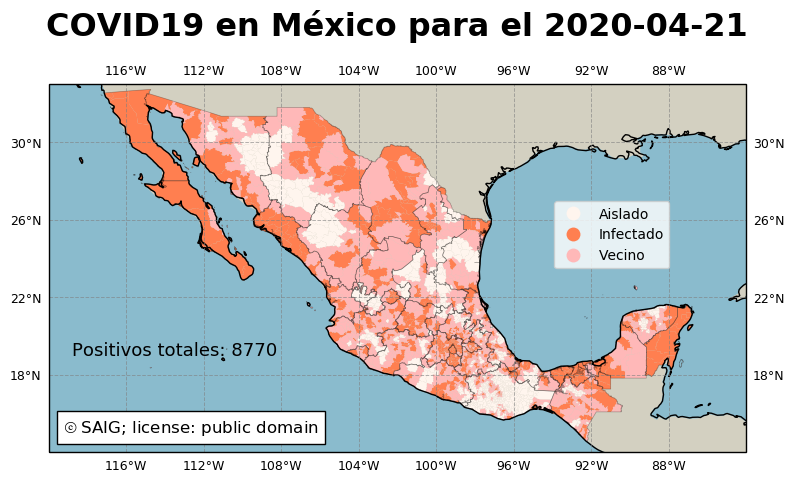

In [28]:
plt.figure(figsize=(9,9),dpi=100)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
xex=[-120,-84, 14, 33]
ax.set_extent(xex, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND,facecolor='#D3D0C1')
ax.add_feature(cfeature.OCEAN,facecolor='#8ABBCD')
colors=['seashell','coral','#FFB8B8']

est.boundary.plot(ax=ax,color='black',linewidth=.5,alpha=.3)

cvmun.plot(ax=ax,legend=True,column='lab',cmap = ListedColormap(colors))
ticks=np.round(np.linspace(0,int(geofq.cnt.max()),10))
leg = ax.get_legend()
leg.set_bbox_to_anchor((.9,.7))
leg.set_draggable(True)


gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.7, color='gray', alpha=0.6, linestyle='--')
gl.xlabels_top = True
gl.ylabels_left = True
gl.xlines = True
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator(np.arange(xex[0], xex[1]+4,4))
gl.ylocator = mticker.FixedLocator(np.arange(xex[2],xex[3]+4,4))
gl.xlabel_style = {'size': 9}
gl.ylabel_style = {'size': 9}
plt.title("COVID19 en México para el "+date.today().isoformat(),pad=35,fontsize=23,fontweight="bold")
plt.text(-118.8,19,"Positivos totales: "+str(np.sum(count.cnt)),fontsize=13)
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                        ''.format(SOURCE, LICENSE),
                        loc=3, prop={'size': 12}, frameon=True)
ax.add_artist(text)
plt.savefig('top'+date.today().isoformat()+'.png',dpi=800,bbox_inches='tight');

In [ ]:
#geocv.to_file('cv200419.shp')